In [1]:
import tensorflow as tf
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import json
import cv2

%matplotlib inline

Using TensorFlow backend.


In [2]:
from variables import *

# Comparing Models
---
### Generating LR, SR and HR images

In [3]:
# Pre-Process initial HR image
def preprocess(image):
    return imresize(image, hr_dim, interp='bicubic', mode=None)

In [4]:
# Loading HR Images
hr = {}
for im in images:
    path = path_images + im + '.png'
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    hr[im] = preprocess(image)
    
# { image_name : image }

/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


In [5]:
# Down-Sampling Function
def downsample(image, sf = scaling_factor):
    image = imresize(image, [int(d/sf) for d in hr_dim], interp='bicubic', mode=None)
    return imresize(image, hr_dim, interp='bicubic', mode=None)

In [6]:
# Generating LR images
lr = {name : downsample(image) for name, image in hr.items()}

# { image_name : image }

/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()
/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [7]:
# Predicting SR images
sr = {}
for model, predict in models.items():
    sr_model = {}
    for name, image in lr.items():
        sr_model[name] = predict(image)
    sr[model] = sr_model
    
# { model_name : { image_name : image } }

/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the

### Generating Models JSON

In [8]:
for model in models:
    results = {}
    # { image_name : { metric : value } } - saved as model.json
    
    for name, image in sr[model].items():
        metric_values = {}
        for metric, func in metrics.items():
            metric_values[metric] = func(image, hr[name])
        results[name] = metric_values
    
    path = path_model_results + model + '.json'
    with open(path, 'w') as file:
        json.dump(results, file)

### Visualizations

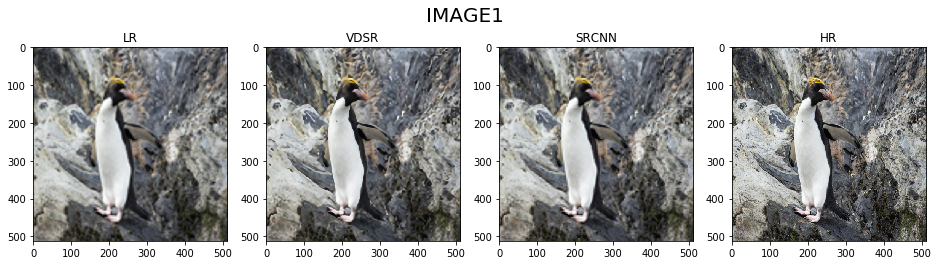

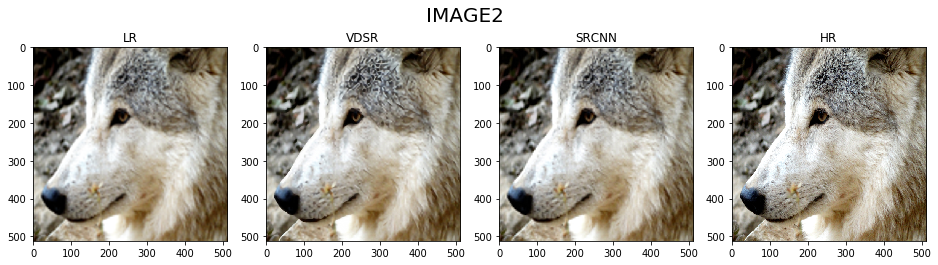

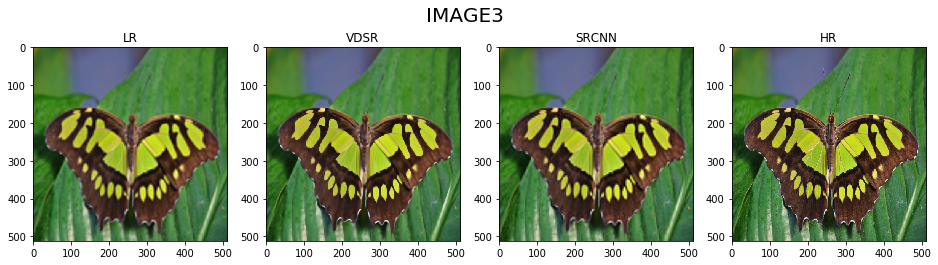

In [9]:
plot_models = models.keys()
plot_images = images

for image in plot_images:
    fig, sub = plt.subplots(1, len(plot_models)+2, figsize=(4*(len(plot_models)+2),4))
    fig.suptitle(image.upper(), size=20)

    sub[0].imshow(cv2.cvtColor(lr[image], cv2.COLOR_BGR2RGB))
    sub[0].set_title('LR')

    for index, model in enumerate(plot_models):
        sub[index+1].imshow(cv2.cvtColor(sr[model][image], cv2.COLOR_BGR2RGB))
        sub[index+1].set_title(model.upper())

    sub[len(plot_models)+1].imshow(cv2.cvtColor(hr[image], cv2.COLOR_BGR2RGB))
    sub[len(plot_models)+1].set_title('HR')

    plt.show()

# Varying Scaling Factors for VDSR
---
### Generating LR, SR images

In [10]:
# Generating LR images
lr_scale = {}
for name, image in hr.items():
    lr_images = {}
    for sf in scaling_factors:
        lr_images[sf] = downsample(image, sf)
    lr_scale[name] = lr_images
    
# { image_name : { scaling_factor : image } }

/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()
/home/navpun31/anaconda3/envs/env3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [11]:
# Predicting SR images
predict = models[scaling_model]
sr_scale = {}
for name, lr_images in lr_scale.items():
    sr_images = {}
    for sf, image in lr_images.items():
        sr_images[sf] = predict(image)
    sr_scale[name] = sr_images

# { image_name : { scaling_factor : image } }

### Scaling Factors JSON

In [12]:
for name, sr_images in sr_scale.items():
    results = {}
    # { scaling_factor : { metric : value } } - saved as image.json
    
    for sf, image in sr_images.items():
        metric_values = {}
        for metric, func in metrics.items():
            metric_values[metric] = func(image, hr[name])
        
        results[str(sf)] = metric_values
    
    path = path_scaling_results + name + '.json'
    with open(path, 'w') as file:
        json.dump(results, file)

### Visualizations

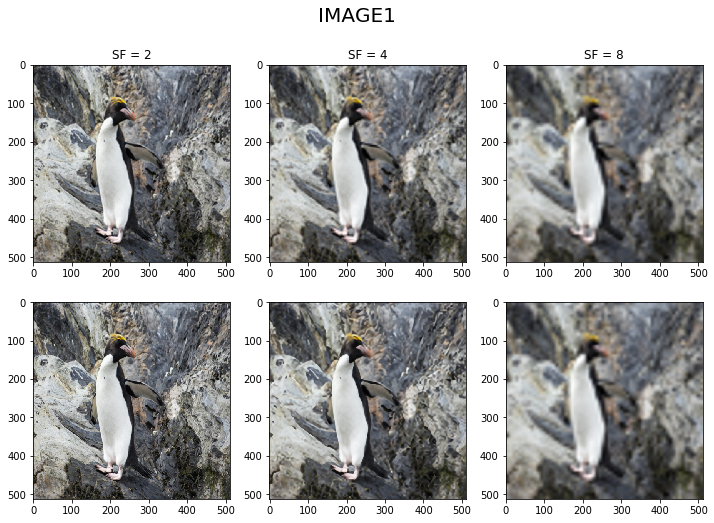

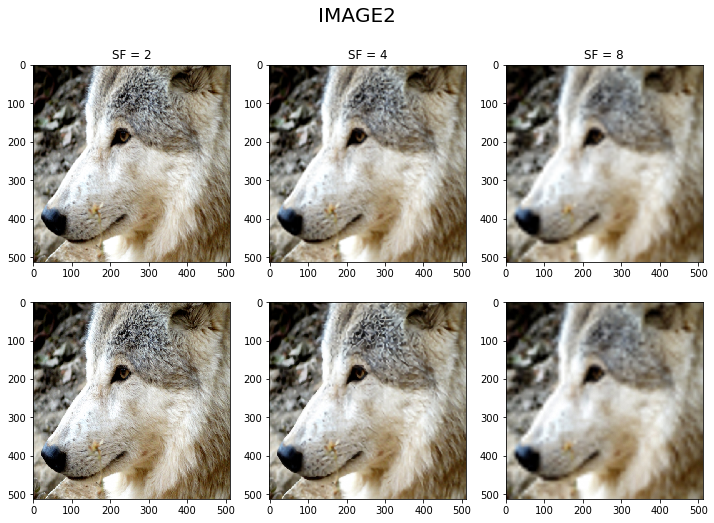

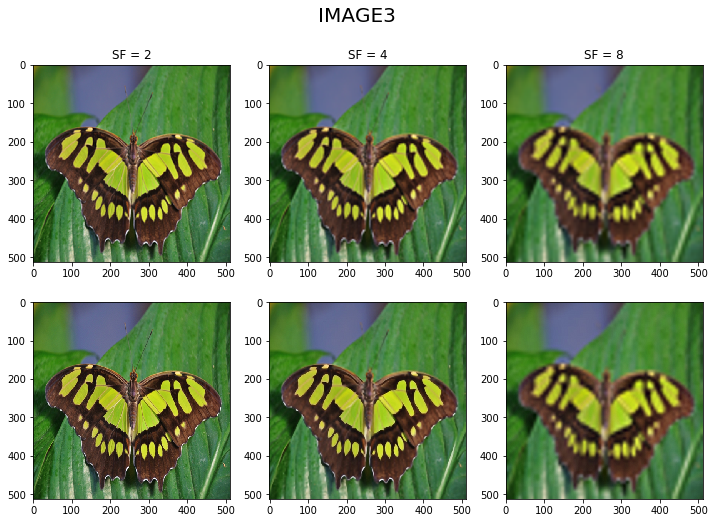

In [13]:
plot_scales = scaling_factors
plot_images = images

for image in plot_images:
    fig, sub = plt.subplots(2, len(plot_scales), figsize=(len(plot_scales)*4,8))
    fig.suptitle(image.upper(), size=20)

    for index, sf in enumerate(plot_scales):
        sub[0,index].imshow(cv2.cvtColor(lr_scale[image][sf], cv2.COLOR_BGR2RGB))
        sub[0,index].set_title('SF = ' + str(sf))
        sub[1,index].imshow(cv2.cvtColor(sr_scale[image][sf], cv2.COLOR_BGR2RGB))